In [ ]:
!nvidia-smi

Sun Aug 11 07:22:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import the drive module from google.colab
from google.colab import drive
import zipfile
import os
# Mount Google Drive to the specified directory '/content/drive'
drive.mount('/content/drive')

# incase you are not storing the file in google drive, set the FILE directory automatically.
# FILE_DIR = '';

Mounted at /content/drive


In [ ]:
# only run this if you have a zipped folder and you wish to unzip it.
zip_path = '/content/drive/MyDrive/MESSIDOR.zip'
extract_path = '/content/riga_data'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Data extracted to {extract_path}")

Data extracted to /content/riga_data


In [ ]:
# Enable inline plotting in Jupyter notebooks
%matplotlib inline
# Standard libraries
import os
from glob import glob
from natsort import natsorted
# Image processing library
import cv2 as cv
# Plotting library
import matplotlib.pyplot as plt
# Machine learning library
from sklearn.model_selection import train_test_split
# Deep learning library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Utility libraries
import warnings
warnings.filterwarnings('ignore')
# TensorFlow Keras layers
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D,
    Conv2DTranspose, Input, Concatenate, Flatten
)
# TensorFlow Keras Model
from tensorflow.keras.models import Model
# TensorFlow Keras metrics
from tensorflow.keras.metrics import Recall, Precision, Accuracy
# Scientific computing libraries
import numpy as np
import pandas as pd
# TensorFlow Keras backend
from tensorflow.keras import backend as K
# TensorFlow Keras callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
# TensorFlow Keras optimizer
from tensorflow.keras.optimizers import Adam
# Image processing libraries
from skimage import color
from skimage.filters import threshold_minimum, threshold_otsu
# Live loss plotting library
# from livelossplot import PlotLossesKeras
from scipy import ndimage as ndi
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label, regionprops

In [ ]:
# Set TensorFlow logging level to minimize log messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Ignore all warning messages
warnings.filterwarnings('ignore')

def display_image_on_axis(axis, image, title):
    """
    Display an image on a specified axis with a title.

    Parameters:
    axis (matplotlib.axes.Axes): The axis on which to display the image.
    image (numpy.ndarray): The image to display.
    title (str): The title of the image.
    """
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def extract_region_of_interest(image):
    """
    Extract the region of interest (ROI) from an image.

    Parameters:
    image (numpy.ndarray): The input image.
    Returns:
    tuple: A tuple containing the extracted ROI and the original image with markings.
    """
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_image, 120, 255, 1)
    contours = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    ROI = image.copy()
    grayscale = cv.cvtColor(ROI, cv.COLOR_BGR2GRAY)

    # Identify and highlight bright spots in the image
    _, max_value, _, max_location = cv.minMaxLoc(grayscale)
    cv.circle(ROI, max_location, 2, (255, 0, 0), 2)

    blurred = cv.GaussianBlur(grayscale, (101, 101), 8)
    _, max_value, _, max_location = cv.minMaxLoc(blurred)

    cv.circle(ROI, max_location, 101, (255, 255, 0), 10)

    height, width = int(max_location[1]), int(max_location[0])
    half_value = int(max_value) // 2 + 40 if height < 600 else 180

    # Crop the image to focus on the region of interest
    cropped_image = image[max(0, height - half_value):height + half_value,
                          max(0, width - half_value):width + half_value]

    return cropped_image, ROI

def display_image(axis, image_path, title):
    """
    Display an image from a file path on a specified axis with a title.

    Parameters:
    axis (matplotlib.axes.Axes): The axis on which to display the image.
    image_path (str): The file path of the image to display.
    title (str): The title of the image.
    """
    img = cv.imread(image_path, cv.IMREAD_COLOR)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    resized_img = cv.resize(img_rgb, (400, 400))

    axis.imshow(resized_img)
    axis.axis('off')
    axis.set_title(title)

def ensure_directory_exists(directory_path):
    """
    Create a directory if it does not already exist.

    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [ ]:
def resize_to_rgb(image_bgr):
    """
    Resize an image to 224x224 pixels and convert it to RGB color space.

    Parameters:
    image_bgr (numpy.ndarray): The input image in BGR color space.

    Returns:
    numpy.ndarray: The resized image in RGB color space.
    """
    resized_image = cv.resize(image_bgr, (400, 400))
    return cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)

def extract_optic_disc_and_cup_masks(image):
    """
    Extract masks for the optic disc and cup from an image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    tuple: A tuple containing the optic disc mask and optic cup mask.
    """
    dark_lower_bound = (10, 10, 0)
    dark_upper_bound = (99, 90, 150)

    mask = cv.inRange(image, dark_lower_bound, dark_upper_bound)
    median_filtered = cv.medianBlur(mask, 5)
    contours, _ = cv.findContours(median_filtered, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours_external, _ = cv.findContours(median_filtered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    optic_disc_mask = mask.copy()
    optic_cup_mask = cv.inRange(image, dark_lower_bound, dark_upper_bound)

    for contour in contours:
        optic_disc_mask = cv.drawContours(optic_disc_mask, [contour], -1, (255, 255, 255), -10)

    for contour in contours_external:
        optic_cup_mask = cv.drawContours(optic_cup_mask, [contour], -1, (0, 0, 0), 10)

    optic_cup_mask_copy = optic_cup_mask.copy()
    median_filtered = cv.medianBlur(optic_cup_mask_copy, 5)
    contours, _ = cv.findContours(median_filtered, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        optic_cup_mask_copy = cv.drawContours(optic_cup_mask_copy, [contour], -1, (255, 255, 255), -10)

    return optic_disc_mask, optic_cup_mask_copy

def create_and_save_optic_cup_images(image_paths, directory_name):
    """
    Create and save optic cup images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    source: https://www.geeksforgeeks.org/delete-a-directory-or-file-using-python/
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        _, optic_cup_mask = extract_optic_disc_and_cup_masks(resized_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), optic_cup_mask)

def create_and_save_optic_disc_images(image_paths, directory_name):
    """
    Create and save optic disc images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        optic_disc_mask, _ = extract_optic_disc_and_cup_masks(resized_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), optic_disc_mask)

def create_and_save_images(image_paths, directory_name):
    """
    Create and save resized RGB images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), resized_image)

In [ ]:
import tensorflow as tf
from keras.layers import Flatten

def intersection_over_union(y_true, y_pred, smooth=1e-15):
    """
    Compute Intersection over Union (IoU) for semantic segmentation.

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: IoU score (Jaccard index).
    """
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_coefficient(y_true, y_pred, smooth=1e-15):
    """
    Compute Dice coefficient for semantic segmentation.
    modified from: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: Dice coefficient score.
    """
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-15):
    """
    Compute Dice loss for semantic segmentation.
    modified from: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: Dice loss.
    """
    return 1.0 - dice_coefficient(y_true, y_pred, smooth)

In [ ]:
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "riga_data")
print(data_dir)

retina_images_2 = glob(os.path.join(data_dir,"MESSIDOR","image*prime.tif"))
retina_masks_2= glob(os.path.join(data_dir,"MESSIDOR","image*-6.tif"))

# get the images from BinRushed1 dataset
retina_images_1 = glob(os.path.join(data_dir,"BinRushed","BinRushed1-Corrected","image*prime.jpg"))
retina_masks_1 = glob(os.path.join(data_dir,"BinRushed","BinRushed1-Corrected","image*-6.jpg"))

# merge them together.
retina_images_2.extend(retina_images_1)
retina_masks_2.extend(retina_masks_1)

retina_image_paths = natsorted(retina_images_2)
retina_mask_paths = natsorted(retina_masks_2)

/content/riga_data


In [ ]:
# Display the count of retina images and masks
print(f"Total retina images: {len(retina_image_paths)}, total ground truth images: {len(retina_mask_paths)}")

# Split the dataset into training and testing sets (90% train, 10% test)
train_images, test_images, train_masks, test_masks = train_test_split(
    retina_image_paths, retina_mask_paths, test_size=0.1, random_state=56
)
# Further split the training set into training and validation sets (75% train, 25% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.25, random_state=56
)

# Define directories to save the processed images and masks
output_dirs = {
    "retina_train": os.path.join(data_dir, "train/retina"),
    "retina_valid": os.path.join(data_dir, "valid/retina"),
    "retina_test": os.path.join(data_dir, "test/retina"),
    "mask_train_disc": os.path.join(data_dir, "mask_train/disc/retina"),
    "mask_valid_disc": os.path.join(data_dir, "mask_valid/disc/retina"),
    "mask_test_disc": os.path.join(data_dir, "mask_test/disc/retina"),
    "mask_train_cup": os.path.join(data_dir, "mask_train/cup/retina"),
    "mask_valid_cup": os.path.join(data_dir, "mask_valid/cup/retina"),
    "mask_test_cup": os.path.join(data_dir, "mask_test/cup/retina")
}

train_images = natsorted(train_images)
train_masks = natsorted(train_masks)

val_masks = natsorted(val_masks)
val_images = natsorted(val_images)

test_masks = natsorted(test_masks)
test_images = natsorted(test_images)

# Process and save the training, validation, and test images
create_and_save_images(train_images, output_dirs["retina_train"])
create_and_save_images(val_images, output_dirs["retina_valid"])
create_and_save_images(test_images, output_dirs["retina_test"])
# Process and save the optic disc masks
create_and_save_optic_disc_images(train_masks, output_dirs["mask_train_disc"])
create_and_save_optic_disc_images(val_masks, output_dirs["mask_valid_disc"])
create_and_save_optic_disc_images(test_masks, output_dirs["mask_test_disc"])
# Process and save the optic cup masks
create_and_save_optic_cup_images(train_masks, output_dirs["mask_train_cup"])
create_and_save_optic_cup_images(val_masks, output_dirs["mask_valid_cup"])
create_and_save_optic_cup_images(test_masks, output_dirs["mask_test_cup"])

Total retina images: 460, total ground truth images: 460


In [ ]:
train = natsorted(glob(os.path.join(output_dirs['retina_train'],"*.*")))
valid = natsorted(glob(os.path.join(output_dirs['retina_valid'],"*.*")))
test = natsorted(glob(os.path.join(output_dirs['retina_test'],"*.*")))

train_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_train_cup'],"*.*")))
train_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_train_disc'],"*.*")))

valid_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_valid_cup'],"*.*")))
valid_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_valid_disc'],"*.*")))

test_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_test_cup'],"*.*")))
test_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_test_disc'],"*.*")))

CDR - loading weights of both optic disc and optic cup models for ease of reusability.

In [ ]:
from tensorflow.keras import models
# loading the models, using the saved model_weights
disc_model_weight = os.path.join(data_dir,"files","optic_disc.keras")
cup_model_weight = os.path.join(data_dir,"files","optic_cup.keras")

disc_model = models.load_model(disc_model_weight, custom_objects={'dice_loss': dice_loss, 'dice_coefficient':dice_coefficient,
                                                                       'intersection_over_union':intersection_over_union})
cup_model = models.load_model(cup_model_weight, custom_objects={'dice_loss': dice_loss, 'dice_coefficient':dice_coefficient,
                                                                       'intersection_over_union':intersection_over_union})

In [ ]:
import os
import cv2 as cv
import numpy as np
from skimage.segmentation import clear_border, mark_boundaries
import matplotlib.pyplot as plt

def display_image_with_prediction(axis, image, title):
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def process_and_save_predictions(images, masks, save_directory, model):
    scores = []
    processed_images = []
    score_dict = {}

    os.chdir(save_directory)
    for idx, image_path in enumerate(images):
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        resized_image = cv.resize(image, (400, 400))
        yuv_image = cv.cvtColor(resized_image, cv.COLOR_RGB2YUV)

        clahe = cv.createCLAHE(clipLimit=1, tileGridSize=(2, 2))
        yuv_image[:, :, 0] = clahe.apply(yuv_image[:, :, 0])
        processed_image = cv.cvtColor(yuv_image, cv.COLOR_YUV2RGB)
        filtered_image = cv.bilateralFilter(processed_image, 9, 75, 75)

        normalized_image = filtered_image / 255.0
        normalized_image = normalized_image.astype(np.float32)
        normalized_image = np.expand_dims(normalized_image, axis=0)

        prediction = model.predict(normalized_image)[0]
        prediction = np.where(prediction > 0.5, 1.0, 0.0)

        refined_prediction = np.squeeze(prediction, axis=-1)
        resized_prediction = cv.resize(refined_prediction, (400, 400))

        # post processing.
        kernel = np.ones((15, 15), np.uint8)
        final_prediction = cv.morphologyEx(resized_prediction, cv.MORPH_OPEN, kernel)
        final_prediction = final_prediction.astype(np.float32)
        # end.

        cv.imwrite(f"prediction-{idx}.jpg", final_prediction)

        ground_truth = cv.imread(masks[idx])
        ground_truth = cv.cvtColor(ground_truth, cv.COLOR_BGR2GRAY)
        ground_truth = ground_truth.astype(np.float32) / 255.0

        dice_score = dice_coefficient(ground_truth, final_prediction, smooth=1)
        scores.append(float(dice_score))
        processed_images.append(final_prediction)
        score_dict[idx] = float(dice_score)

    return np.mean(scores) * 100, score_dict, processed_images, scores

# Directories for saving results for optic cup
result_train_folder_cup = os.path.join(data_dir, "result/train/cup")
result_valid_folder_cup = os.path.join(data_dir, "result/valid/cup")
result_test_folder_cup = os.path.join(data_dir,"result/test/cup")

# Directories for saving results for optic disc
result_train_folder_disc = os.path.join(data_dir, "result/train/disc")
result_valid_folder_disc = os.path.join(data_dir, "result/valid/disc")
result_test_folder_disc = os.path.join(data_dir,"result/test/disc")

ensure_directory_exists(result_train_folder_cup)
ensure_directory_exists(result_valid_folder_cup)
ensure_directory_exists(result_test_folder_cup)

ensure_directory_exists(result_train_folder_disc)
ensure_directory_exists(result_valid_folder_disc)
ensure_directory_exists(result_test_folder_disc)

Computing the dice coeficient score across the train, validation and test images.

In [ ]:
# Generating predictions and saving results for optic cup
train_score, train_dict, train_images, train_scores = process_and_save_predictions(train, train_mask_cup, result_train_folder_cup, cup_model)
valid_score, valid_dict, valid_images, valid_scores = process_and_save_predictions(valid, valid_mask_cup, result_valid_folder_cup, cup_model)
test_score, test_dict, test_images, test_scores = process_and_save_predictions(test, test_mask_cup, result_test_folder_cup, cup_model)

# Sorting results for display for optic cup
train_top_scores = sorted(train_dict, reverse=True)[:4]
valid_top_scores = sorted(valid_dict, reverse=True)[:4]
test_top_scores = sorted(test_dict, reverse=True)[:4]

train_top_values = sorted(train_scores, reverse=True)[:4]
valid_top_values = sorted(valid_scores, reverse=True)[:4]
test_top_values = sorted(test_scores, reverse=True)[:4]

print(f"Train Dice Coefficient Score for optic cup: {train_score:.2f}")
print(f"Validation Dice Coefficient Score for optic cup: {valid_score:.2f}")
print(f"Test Dice Coefficient Score for optic cup: {test_score:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Generating predictions and saving results for optic disc
train_score2, train_dict2, train_images2, train_scores2 = process_and_save_predictions(train, train_mask_disc, result_train_folder_disc, disc_model)
valid_score2, valid_dict2, valid_images2, valid_scores2 = process_and_save_predictions(valid, valid_mask_disc, result_valid_folder_disc, disc_model)
test_score2, test_dict2, test_images2, test_scores2 = process_and_save_predictions(test, test_mask_disc, result_test_folder_disc, disc_model)

# Sorting results for display
train_top_scores2 = sorted(train_dict2, reverse=True)[:4]
valid_top_scores2 = sorted(valid_dict2, reverse=True)[:4]
test_top_scores2 = sorted(test_dict2, reverse=True)[:4]

train_top_values2 = sorted(train_scores2, reverse=True)[:4]
valid_top_values2 = sorted(valid_scores2, reverse=True)[:4]
test_top_values2 = sorted(test_scores2, reverse=True)[:4]

print(f"Train Dice Coefficient Score: {train_score2:.2f}")
print(f"Validation Dice Coefficient Score: {valid_score2:.2f}")
print(f"Test Dice Coefficient Score: {test_score2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

CDR analysis for Optic disc and cup

In [ ]:
def get_mask_area(mask):
    # Convert the mask to uint8 type
    mask = mask.astype(np.uint8)
    # Find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # If no contours are found, the mask area is 0
    if not contours:
        return 0.0
    # Calculate the areas of all contours and return the largest
    return max(cv.contourArea(c) for c in contours)

def get_marker(image, pred_disc, pred_cup):
    # Mark the boundaries of the predicted disc and cup on the image
    marked_image = mark_boundaries(image, pred_disc, mode='thick', outline_color=(0, 255, 255), color=(0, 255, 255))
    marked_image = mark_boundaries(marked_image, pred_cup, mode='thick', outline_color=(0, 0, 255), color=(0, 0, 255))

    return marked_image


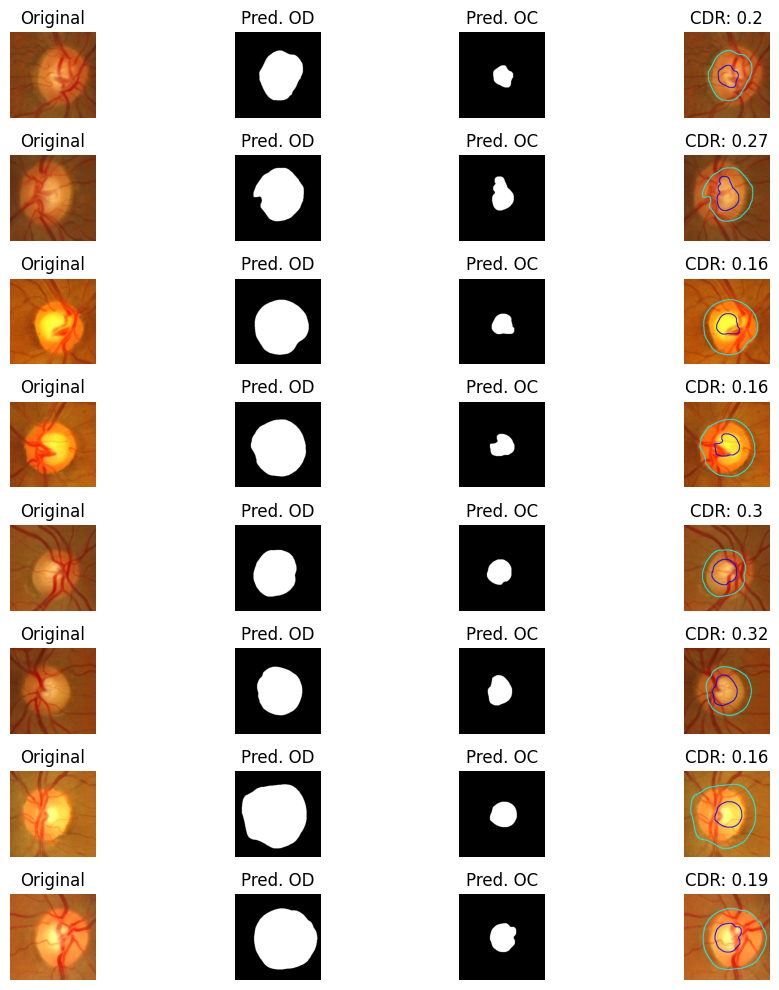

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

def show_oc_and_od(axis, image, title):
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(10, 10))

for b in range(min(len(train_dict2), 8)):  # Limit to 8 rows
    # Original image
    image = cv.imread(train[b], cv.IMREAD_COLOR)

    # Predicted disc
    pred_disc = train_images2[b]
    disc_area = get_mask_area(pred_disc)  # Getting the disc area

    # Predicted cup
    pred_cup = train_images[b]
    cup_area = get_mask_area(pred_cup)  # Getting the cup area

    # Getting the CDR
    combined_image = get_marker(image, pred_disc, pred_cup)
    cdr = round(cup_area / disc_area, 2)

    # Displaying images
    show_oc_and_od(ax[b, 0], image, "Original")
    show_oc_and_od(ax[b, 1], pred_disc, "Pred. OD")
    show_oc_and_od(ax[b, 2], pred_cup, "Pred. OC")
    show_oc_and_od(ax[b, 3], combined_image, f"CDR: {cdr}")

plt.tight_layout()
plt.show()

Comparative analysis of predicted mask with Ground truth mask


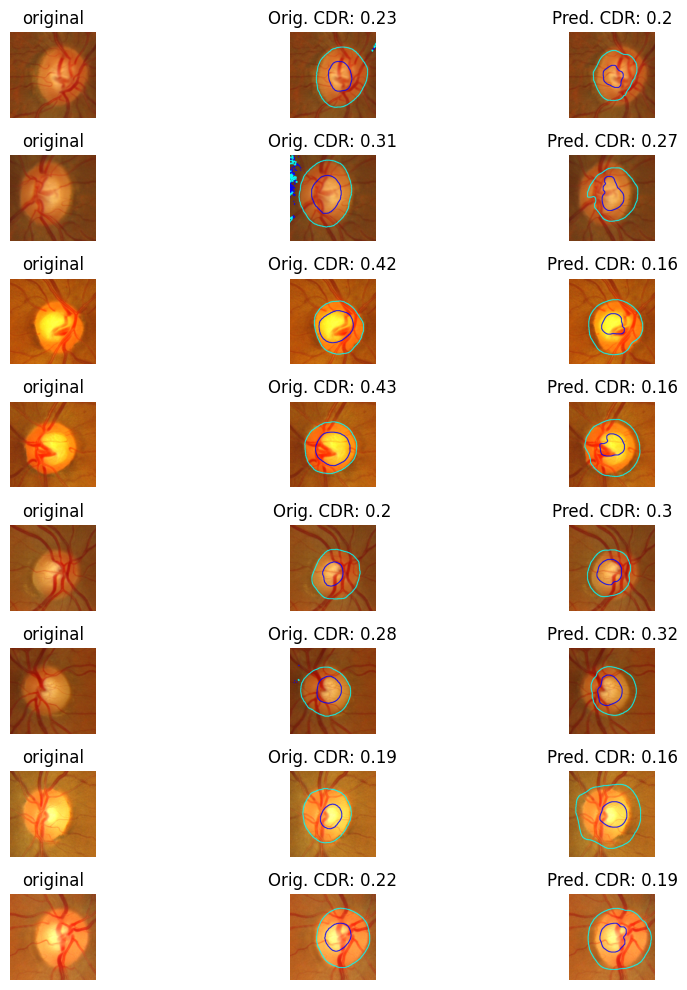

In [ ]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(10,10))
for b in range(min(len(train_dict2), 8)):  # Limit to 8 rows
    # original image
    image = cv.imread(train[b])
    # ground truth disc
    disc = cv.imread(train_mask_disc[b])
    disc = cv.cvtColor(disc, cv.COLOR_BGR2GRAY)
    orig_disc_area = get_mask_area(disc) # get the disc area
    # ground truth cup
    cup = cv.imread(train_mask_cup[b])
    cup = cv.cvtColor(cup, cv.COLOR_BGR2GRAY)
    orig_cup_area = get_mask_area(cup) # get the cup area
    # overlapping the orig_disc, cup and image
    combined_image_orig = get_marker(image, disc, cup)
    cdr_orig = round(orig_cup_area/orig_disc_area, 2)
    # predicted disc
    pred_disc = train_images2[b]
    disc_area = get_mask_area(pred_disc) # getting the disc area.
    # predicted cup
    pred_cup = train_images[b]
    cup_area = get_mask_area(pred_cup) # getting the cup area.
    # getting the CDR
    # oevrlapping the image, optic disc and optic cup together.
    combined_image_pred = get_marker(image, pred_disc, pred_cup)
    cdr_pred = round(cup_area/disc_area, 2)

    show_oc_and_od(ax[b,0], image, "original")
    show_oc_and_od(ax[b,1], combined_image_orig, "Orig. CDR: "+str(cdr_orig))
    show_oc_and_od(ax[b,2], combined_image_pred, "Pred. CDR: "+str(cdr_pred))

plt.tight_layout()
plt.show()

Function to test independent images.

In [ ]:
def predict_image(image, model):
    # convert to yuv
    # yuv_image = cv.cvtColor(image, cv.COLOR_RGB2YUV)
    # # enhance image quality
    # clahe = cv.createCLAHE(clipLimit=1, tileGridSize=(2, 2))
    # yuv_image[:, :, 0] = clahe.apply(yuv_image[:, :, 0])
    # processed_image = cv.cvtColor(yuv_image, cv.COLOR_YUV2RGB)
    # filtered_image = cv.bilateralFilter(processed_image, 9, 75, 75)
    # normalize image to 0...1
    normalized_image = image / 255.0
    normalized_image = normalized_image.astype(np.float32)
    normalized_image = np.expand_dims(normalized_image, axis=0)
    # make prediction
    prediction = model.predict(normalized_image)[0]
    prediction = np.where(prediction > 0.5, 1.0, 0.0)
    # post processing.
    refined_prediction = np.squeeze(prediction, axis=-1)
    resized_prediction = cv.resize(refined_prediction, (400, 400))
    kernel = np.ones((15, 15), np.uint8)
    final_prediction = cv.morphologyEx(resized_prediction, cv.MORPH_OPEN, kernel)
    final_prediction = final_prediction.astype(np.float32)

    return final_prediction


def perform_testing(pos_i, ret_image, orig_disc, orig_cup, disc_model, cup_model):
    # preprocess the image at this point.
    image = cv.imread(ret_image[pos_i], cv.IMREAD_COLOR)
    resized_image2 = image.copy()

    # Original disc
    ret_disc = cv.imread(orig_disc[pos_i])
    ret_disc = cv.cvtColor(ret_disc, cv.COLOR_BGR2GRAY)
    orig_disc_area = get_mask_area(ret_disc) # get the disc area
    # ground truth cup
    ret_cup = cv.imread(orig_cup[pos_i])
    ret_cup = cv.cvtColor(ret_cup, cv.COLOR_BGR2GRAY)
    orig_cup_area = get_mask_area(ret_cup)

    # overlapping the orig_disc, cup and image
    combined_image_orig = get_marker(resized_image2, ret_disc, ret_cup)
    cdr_orig = round(orig_cup_area/orig_disc_area, 2)

    # predicted cup and disc
    resized_image = resize_to_rgb(image.copy())
    cup_pred = predict_image(resized_image, cup_model)
    cup_area = get_mask_area(cup_pred) # getting the cup area.

    disc_pred = predict_image(resized_image, disc_model)
    disc_area = get_mask_area(disc_pred) # getting the disc area.

    # overlapping the pred_disc, cup and image
    combined_image_pred = get_marker(resized_image2, disc_pred, cup_pred)
    cdr_pred = round(cup_area/disc_area, 2)

    return image, resized_image2, combined_image_orig, cdr_orig, cup_pred, disc_pred, combined_image_pred, cdr_pred

for reference.

train = natsorted(glob(os.path.join(output_dirs['retina_train'],"*.*")))

valid = natsorted(glob(os.path.join(output_dirs['retina_valid'],"*.*")))

test = natsorted(glob(os.path.join(output_dirs['retina_test'],"*.*")))

train_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_train_cup'],"*.*")))

train_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_train_disc'],"*.*")))

valid_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_valid_cup'],"*.*")))

valid_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_valid_disc'],"*.*")))

test_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_test_cup'],"*.*")))

test_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_test_disc'],"*.*")))

Please enter position of image you wish to predict: 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


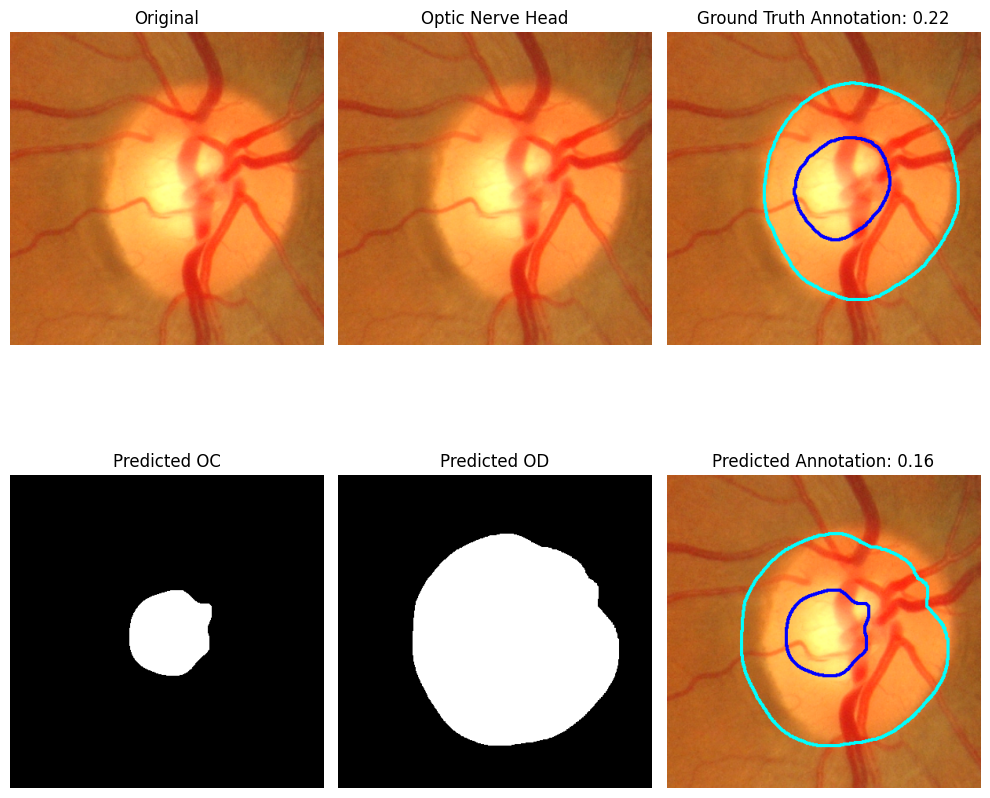

In [ ]:
POSITION = input(f'Please enter position of image you wish to predict: ' )

while not POSITION.isdigit():
    print(f"Invalid input. Please enter an integer")
    POSITION = input('Please enter the position of the image you wish to predict: ')

# Now POSITION is guaranteed to be a valid integer string
pos_i = int(POSITION)
image_path = pos_i

# Based on what you are trying. For train or Valid or Test. Your choice. Just change.
image = train
orig_disc = train_mask_disc
orig_cup = train_mask_cup

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
ret_im, optic_head, ground_mark, cdr_1, pred_cup, pred_disc, pred_mark, cdr_2= perform_testing(
    pos_i, image, orig_disc, orig_cup, disc_model, cup_model)
show_oc_and_od(ax[0, 0], ret_im, "Original")
show_oc_and_od(ax[0, 1], optic_head, "Optic Nerve Head")
show_oc_and_od(ax[0, 2], ground_mark, f"Ground Truth Annotation: {cdr_1}")
show_oc_and_od(ax[1, 0], pred_cup, "Predicted OC")
show_oc_and_od(ax[1, 1], pred_disc, "Predicted OD")
show_oc_and_od(ax[1, 2], pred_mark, f"Predicted Annotation: {cdr_2}")

plt.tight_layout()
plt.show()

In [ ]:
# Function to identify the last convolutional layer in a model
def find_last_conv_layer(model):
    """
    Identify the last convolutional layer in the given model.

    Parameters:
        model (Model): The Keras model instance.

    Returns:
        str: The name of the last convolutional layer.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    return None

# Retrieve the name of the last convolutional layer
last_conv_disc_layer = find_last_conv_layer(disc_model)
last_conv_cup_layer = find_last_conv_layer(cup_model)

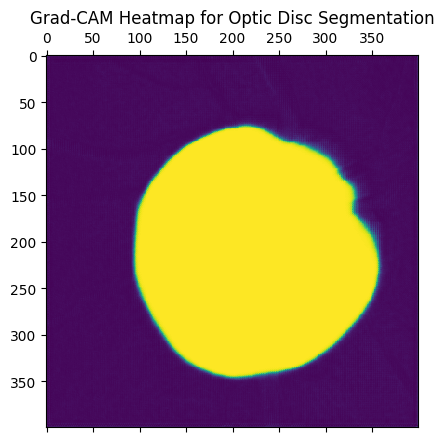

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path, target_size=(400, 400)):
    """
    Load and preprocess an image.

    Parameters:
        img_path (str): Path to the image file.
        target_size (tuple): Desired image size.

    Returns:
        numpy.array: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

img_path = train[image_path]  # Replace with your image path
input_image = preprocess_image(img_path)

def generate_gradcam_heatmap(model, img_array, conv_layer_name):
    """
    Generate a Grad-CAM heatmap for a given model and image.

    Parameters:
        model (Model): The Keras model.
        img_array (numpy.array): Preprocessed input image.
        conv_layer_name (str): Name of the convolutional layer.

    Returns:
        numpy.array: Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Use the last convolutional layer before the output
last_conv_layer_name = last_conv_disc_layer

# Compute Grad-CAM
heatmap = generate_gradcam_heatmap(disc_model, input_image, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap for Optic Disc Segmentation")
plt.show()


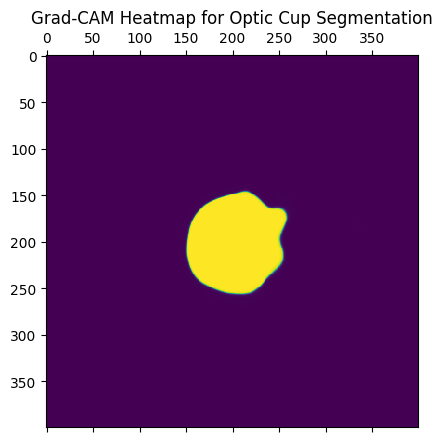

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path, target_size=(400, 400)):
    """
    Load and preprocess an image.

    Parameters:
        img_path (str): Path to the image file.
        target_size (tuple): Desired image size.

    Returns:
        numpy.array: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

img_path = train[image_path]  # Replace with your image path
input_image = preprocess_image(img_path)

def generate_gradcam_heatmap(model, img_array, conv_layer_name):
    """
    Generate a Grad-CAM heatmap for a given model and image.

    Parameters:
        model (Model): The Keras model.
        img_array (numpy.array): Preprocessed input image.
        conv_layer_name (str): Name of the convolutional layer.

    Returns:
        numpy.array: Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Use the last convolutional layer before the output
last_conv_layer_name = last_conv_cup_layer

# Compute Grad-CAM
heatmap2 = generate_gradcam_heatmap(cup_model, input_image, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap2)
plt.title("Grad-CAM Heatmap for Optic Cup Segmentation")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from keras.preprocessing.image import load_img, img_to_array

def apply_mask_overlay(mask1, mask2, image_path, alpha=0.4, colormap1='jet', colormap2='viridis'):
    """
    Apply two binary mask overlays with different colors on the original image.

    Parameters:
        mask1 (numpy.array): The first binary mask.
        mask2 (numpy.array): The second binary mask.
        image_path (str): Path to the original image.
        alpha (float): Transparency level of the overlay.
        colormap1 (str): Colormap to use for the first mask.
        colormap2 (str): Colormap to use for the second mask.

    Returns:
        numpy.array: Image with the mask overlay.
    """
    # Load the original image
    image = cv.imread(image_path, cv.IMREAD_COLOR)

    # Normalize the masks to the range 0-255
    mask1 = np.uint8(mask1 * 255)  # Assuming mask is in the range [0, 1]
    mask2 = np.uint8(mask2 * 255)  # Assuming mask is in the range [0, 1]

    # Apply the colormaps to the masks to create a pseudo-heatmap
    colormap1 = plt.cm.get_cmap(colormap1)
    colored_mask1 = colormap1(mask1)

    colormap2 = plt.cm.get_cmap(colormap2)
    colored_mask2 = colormap2(mask2)

    # Convert the colormaps to RGB
    colored_mask1 = np.uint8(colored_mask1[:, :, :3] * 255)
    colored_mask2 = np.uint8(colored_mask2[:, :, :3] * 255)

    # Resize the colored_masks to match the original image size (if necessary)
    colored_mask1 = cv.resize(colored_mask1, (image.shape[1], image.shape[0]))
    colored_mask2 = cv.resize(colored_mask2, (image.shape[1], image.shape[0]))

    # Combine the two masks with the original image
    overlay_image = cv.addWeighted(image, 1 - alpha, colored_mask1, alpha, 0)
    overlay_image = cv.addWeighted(overlay_image, 1, colored_mask2, alpha, 0)

    return overlay_image

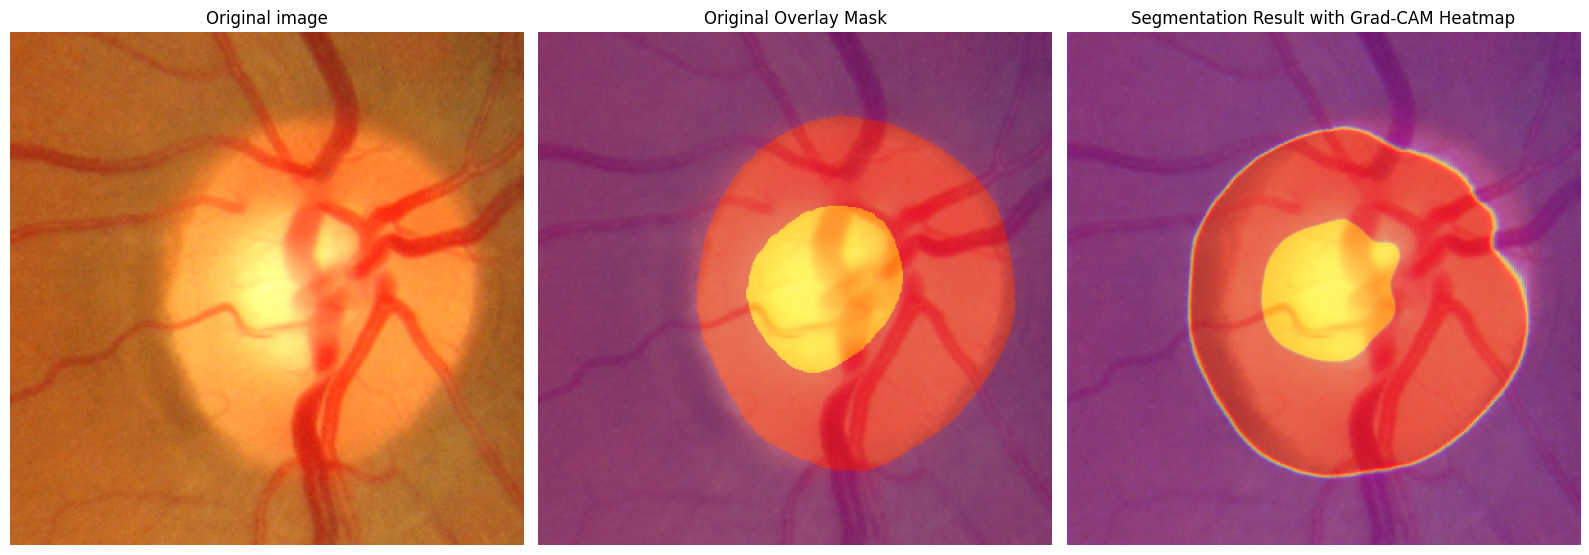

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv  # Assuming you meant cv2 for OpenCV
from keras.preprocessing.image import load_img, img_to_array

def apply_heatmap_overlay(heatmap, heatmap2, image_path, alpha=0.4, colormap1='jet', colormap2='viridis'):
    """
    Apply two heatmap overlays with different colors on the original image.

    Parameters:
        heatmap (numpy.array): The first heatmap.
        heatmap2 (numpy.array): The second heatmap.
        image_path (str): Path to the original image.
        alpha (float): Transparency level of the overlay.
        colormap1 (str): Colormap to use for the first heatmap.
        colormap2 (str): Colormap to use for the second heatmap.

    Returns:
        numpy.array: Image with the heatmap overlay.
    """
    # Load the original image
    image = cv.imread(image_path, cv.IMREAD_COLOR)

    # Normalize the heatmaps to the range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap2 = np.uint8(255 * heatmap2)

    # Apply the colormaps to the heatmaps
    colormap1 = plt.cm.get_cmap(colormap1)
    colored_heatmap1 = colormap1(heatmap)

    colormap2 = plt.cm.get_cmap(colormap2)
    colored_heatmap2 = colormap2(heatmap2)

    # Convert the colormaps to RGB
    colored_heatmap1 = np.uint8(colored_heatmap1[:, :, :3] * 255)
    colored_heatmap2 = np.uint8(colored_heatmap2[:, :, :3] * 255)

    # Resize the colored_heatmaps to match the original image size (if necessary)
    colored_heatmap1 = cv.resize(colored_heatmap1, (image.shape[1], image.shape[0]))
    colored_heatmap2 = cv.resize(colored_heatmap2, (image.shape[1], image.shape[0]))

    # Combine the two heatmaps with the original image
    overlay_image = cv.addWeighted(image, 1 - alpha, colored_heatmap1, alpha, 0)
    overlay_image = cv.addWeighted(overlay_image, 1, colored_heatmap2, alpha, 0)

    return overlay_image

# Apply the heatmap overlay on the original image
overlay_image = apply_heatmap_overlay(heatmap, heatmap2, img_path)
mask_disc = cv.imread(train_mask_disc[image_path], cv.IMREAD_GRAYSCALE)
mask_cup = cv.imread(train_mask_cup[image_path], cv.IMREAD_GRAYSCALE)

# Assuming the masks are binary (0 and 1), normalize them
mask_disc = mask_disc / 255.0
mask_cup = mask_cup / 255.0
overlay_mask = apply_mask_overlay(mask_disc, mask_cup, img_path)

# Display the original image and the heatmap overlay
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))
display_image_on_axis(axes[0], cv.imread(train[image_path], cv.IMREAD_COLOR), f"Original image")
axes[1].imshow(overlay_mask)
axes[1].axis('off')
axes[1].set_title("Original Overlay Mask")
axes[2].imshow(overlay_image)
axes[2].axis('off')
axes[2].set_title("Segmentation Result with Grad-CAM Heatmap")
plt.tight_layout()
plt.show()